# Data splitting, preprocessing, augmentation in Vanilla Pytorch

Will likely try to use FastAI for this at some point, as they have a more efficient transforms/augmentations, although the API is a little bit more tricky to use

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from abc import abstractmethod
from typing import Any, Tuple, List, Dict, Union, Optional
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as dl

In [2]:
unlabeled_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

labeled_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=None)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=labeled_transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43922822.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
def get_indices(n_initial: int, X_size: int) -> np.ndarray:
  """
  This function generates the indices for the starting pool
  n_initial: size of the initial starting pool
  X_size: size of the full dataset
  """
  return np.random.choice(range(X_size), size=n_initial, replace=False)

# this probably needs refactoring at some stage
def get_pools(dataset: Any, labeled_idx: np.ndarray, unlabeled_idx: np.ndarray) -> Tuple[Any, Any]:
  """
  This function returns a tuple containing the labeled and unlabled pools
  dataset: raw dataset before splitting, should be an array-like data structure which support indexing
  initial_idx: indices for the starting pool
  """
  labeled_idxes = set(labeled_idx.flatten())
  unlabeled_idxes = set(unlabeled_idx.flatten())
  labeled_pool, unlabeled_pool = [], []
  for idx, sample in enumerate(dataset):
    if idx in labeled_idxes:
      labeled_pool.append(sample)
    elif idx in unlabeled_idxes:
      unlabeled_pool.append(sample)
  return labeled_pool, unlabeled_pool


In [4]:
# create labeled and unlabeled pools
starting_indices = get_indices(n_initial=256, X_size=len(trainset))
labeled_indices = starting_indices[:128]
unlabeled_indices = starting_indices[128:]
labeled_pool, unlabeled_pool = get_pools(dataset=trainset, labeled_idx=labeled_indices, unlabeled_idx=unlabeled_indices)

In [5]:
class CIFARALDataset(Dataset):
  def __init__(self, labeled_dataset: Union[np.ndarray, List], unlabeled_dataset: Optional[Union[np.ndarray, List]]):
    self.labeled_dataset = labeled_dataset
    self.unlabeled_dataset = unlabeled_dataset

  def __len__(self) -> int:
    return len(self.labeled_dataset)

  @abstractmethod
  def __getitem__(self, idx: int) -> None:
    raise NotImplementedError("This method needs to be implemented for a dataset to be created")

class SSLDataset(CIFARALDataset):

  def __init__(self, labeled_dataset: Union[np.ndarray, List], unlabeled_dataset: Union[np.ndarray, List]):
    super().__init__(labeled_dataset=labeled_dataset, unlabeled_dataset=unlabeled_dataset)

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
    ll_image, label = self.labeled_dataset[idx]
    ul_image, _ = self.unlabeled_dataset[idx]
    return torch.cat([labeled_transform(ll_image), labeled_transform(ul_image), unlabeled_transform(ul_image)], dim=0), label

class TestDataset(Dataset):

  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx: int):
    return self.dataset[idx]

class SLDataset(CIFARALDataset):

  def __init__(self, labeled_dataset: Union[np.ndarray, List]):
    super().__init__(labeled_dataset=labeled_dataset, unlabeled_dataset=None)

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
      image, label = self.labeled_dataset[idx]
      return labeled_transform(image), label

In [6]:
train_bs, test_bs = 32, 64
test_set = [testset[i] for i in range(8192)]

ssl_dataloader = dl(dataset=SSLDataset(labeled_dataset=labeled_pool, unlabeled_dataset=unlabeled_pool),
                                batch_size=train_bs,
                                shuffle=True,
                                num_workers=2)

sl_dataloader = dl(dataset=SLDataset(labeled_dataset=labeled_pool),
                                  batch_size=train_bs,
                                  shuffle=True,
                                  num_workers=2)

test_dataloader = dl(dataset=TestDataset(dataset=test_set),
                     batch_size=test_bs,
                     shuffle=True,
                     num_workers=2)

# Training in Vanilla Pytorch

In [ ]:
# load wide resnet 50 model

model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model.fc = torch.nn.Linear(in_features=2048, out_features=10, bias=True)

In [8]:
# freeze model layers --> need to refactor this as well

for i, child in enumerate(model.children()):
  if i < 9:
    for param in child.parameters():
      param.requires_grad = False

In [ ]:
num_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0004)
supervised_criterion = torch.nn.CrossEntropyLoss()
unsupervised_criterion = torch.nn.KLDivLoss(reduction="batchmean")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    total_correct, total_samples = 0, 0
    model.train()
    for i, data in enumerate(ssl_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        # labeled_img, labels = data
        # unlabeled_img, unlabeled_aug_img = next(iter(unlabeled_dataloader))
        x, labels = data
        labeled_img, unlabeled_img, unlabeled_aug_img = x[:, :3, ...], x[:, 3:6, ...], x[:, 6:, ...]

        labeled_img = labeled_img.to(device)
        labels = labels.to(device)
        unlabeled_img = unlabeled_img.to(device)
        unlabeled_aug_img = unlabeled_aug_img.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_logits = model(labeled_img)
        unaug_logits = F.softmax(model(unlabeled_img), dim=1)
        aug_logits = F.log_softmax(model(unlabeled_aug_img), dim=1)
        loss_l = supervised_criterion(predicted_logits, labels)
        loss_u = unsupervised_criterion(aug_logits, unaug_logits)
        print(f"Loss_l: {loss_l}, Loss_u: {loss_u}")
        loss = loss_l
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(f'[Epoch: {epoch + 1}, Batch: {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        running_loss = 0.0

    model.eval()
    with torch.no_grad():
      for j, data in enumerate(test_dataloader):
        labeled_img, labels = data
        labeled_img = labeled_img.to(device)
        labels = labels.to(device)
        preds = model(labeled_img)
        loss = supervised_criterion(preds, labels)
        _, predicted = torch.max(preds, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
      accuracy = 100 * total_correct / total_samples
      print(f'Accuracy = {accuracy:.2f}%')

# Training in FastAI

Decided to use this approach to try and figure out what the "optimal" learning rate was, as the previous loss was having issues converging.

In [ ]:
from fastai.vision.all import *

In [ ]:
LayerFunc = Callable[[nn.Module],None]

def _bn(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv2d(ni, nf, ks, stride))

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

def conv2d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv2d:
    "Create and initialize `nn.Conv2d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

class BasicBlock(Module):
    "Block to from a wide ResNet."
    def __init__(self, ni, nf, stride, drop_p=0.0):
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv2d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

class WideResNet(Module):
      "Wide ResNet with `num_groups` and a width of `k`."
      def __init__(self, num_groups:int, N:int, num_classes:int, k:int=1, drop_p:float=0.0, start_nf:int=16, n_in_channels:int=3):
          n_channels = [start_nf]
          for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

          layers = [conv2d(n_in_channels, n_channels[0], 3, 1)]  # conv1
          for i in range(num_groups):
              layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, (1 if i==0 else 2), drop_p)

          layers += [nn.BatchNorm2d(n_channels[num_groups]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
                    Flatten(), nn.Linear(n_channels[num_groups], num_classes)]
          self.features = nn.Sequential(*layers)

      def forward(self, x): return self.features(x)

class Net(Module):

  def __init__(self):
    self.model = WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32)

  def forward(self, x):
    if x.shape[1] == 9:
      ll, ull, ull_aug = x[:, :3, ...], x[:, 3:6, ...], x[:, 6:, ...]
      x = torch.cat([ll, ull, ull_aug], dim=0)
    return self.model(x)

In [ ]:
unsupervised_criterion = torch.nn.KLDivLoss(reduction="batchmean")
# unsupervised_criterion = torch.nn.MSELoss(reduction="mean")

def sl_loss_func(out, targ):
  return CrossEntropyLossFlat()(out, targ.long())

def ssl_loss_func(out, targ):
  if out.shape[0] != test_bs:
    bs = out.shape[0] // 3
    ll_tensor, ull_tensor, ull_aug_tensor = out[:bs, ...], out[bs:2*bs, ...], out[2*bs:3*bs, ...]
    unaug_logits = F.softmax(ull_tensor, dim=1)
    aug_logits = F.log_softmax(ull_aug_tensor, dim=1)
    loss_u = unsupervised_criterion(aug_logits, unaug_logits)
    loss_l = CrossEntropyLossFlat()(ll_tensor, targ.long())
    return loss_u + loss_l
  else:
    return CrossEntropyLossFlat()(out, targ.long())

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
data_semi_supervised = DataLoaders(ssl_dataloader, test_dataloader)
learn_semi_supervised = Learner(data_semi_supervised,Net(),loss_func=ssl_loss_func,metrics=accuracy, cbs=[Recorder])

SuggestedLRs(valley=0.0002290867705596611)

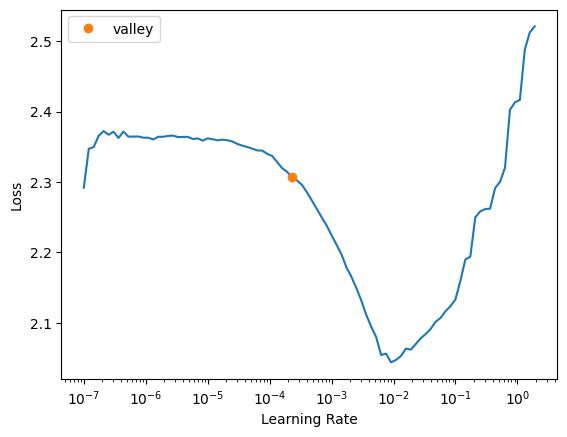

In [ ]:
learn_semi_supervised.lr_find()

In [ ]:
learn_semi_supervised.fit_one_cycle(20, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.364592,2.300520,0.092407,00:04
0,2.364592,2.300520,0.092407,00:04
1,2.347910,2.294795,0.122681,00:04
1,2.347910,2.294795,0.122681,00:04
2,2.312612,2.286709,0.124146,00:04
2,2.312612,2.286709,0.124146,00:04
3,2.264447,2.271705,0.134399,00:04
3,2.264447,2.271705,0.134399,00:04
4,2.207881,2.253399,0.174927,00:04
4,2.207881,2.253399,0.174927,00:04


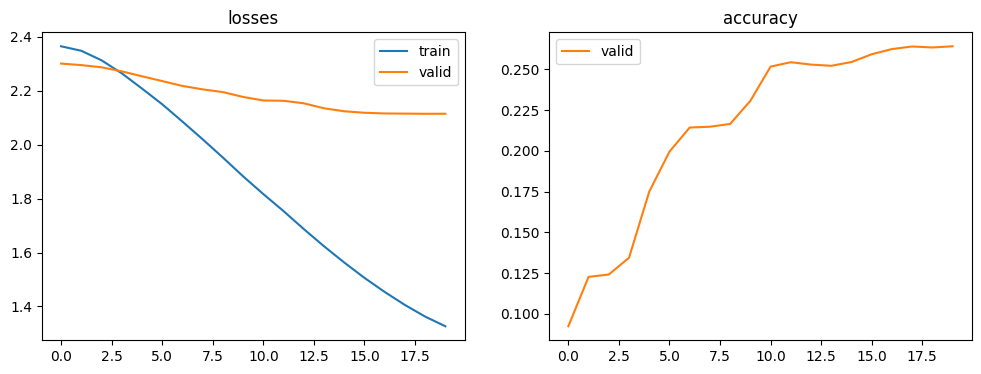

In [ ]:
learn_semi_supervised.recorder.plot_metrics()

In [ ]:
data_supervised = DataLoaders(sl_dataloader, test_dataloader)
learn_supervised = Learner(data_supervised,Net(),loss_func=sl_loss_func,metrics=accuracy, cbs=[Recorder])

SuggestedLRs(valley=0.0004786300996784121)

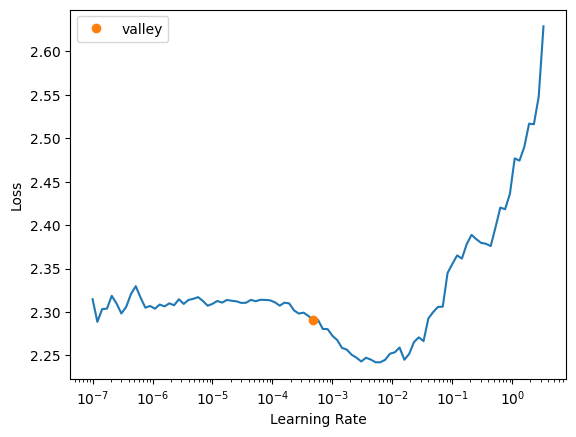

In [ ]:
learn_supervised.lr_find()

In [ ]:
learn_supervised.fine_tune(20, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.290252,2.301128,0.114136,00:04
0,2.290252,2.301128,0.114136,00:04


epoch,train_loss,valid_loss,accuracy,time
0,2.122851,2.300768,0.149170,00:04
0,2.122851,2.300768,0.149170,00:04
1,2.085531,2.330901,0.151123,00:04
1,2.085531,2.330901,0.151123,00:04
2,2.051888,2.445000,0.158813,00:04
2,2.051888,2.445000,0.158813,00:04
3,2.029721,2.504644,0.176880,00:04
3,2.029721,2.504644,0.176880,00:04
4,1.982460,2.295699,0.205688,00:04
4,1.982460,2.295699,0.205688,00:04


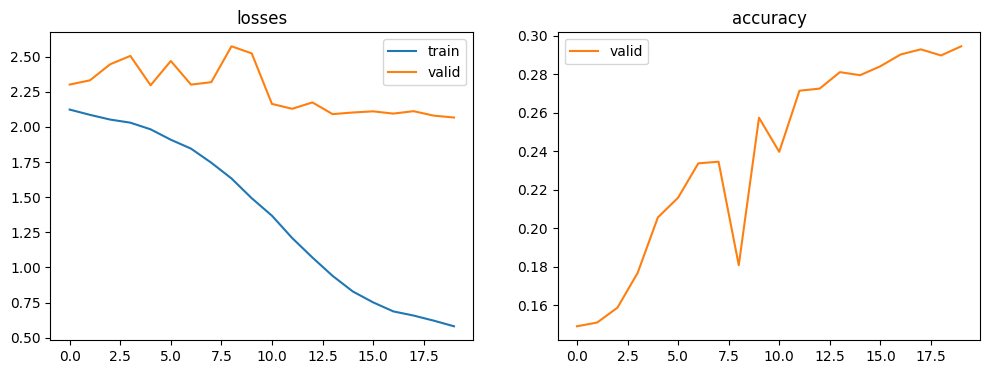

In [ ]:
learn_supervised.recorder.plot_metrics()

# Part 2: Creating experimental AL pipeline with modAL